In [638]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v2 import preprocess_input
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout

Import needed packages then make variable of the file paths to the image folders.

In [639]:
tumor_dir = '.\Brain Tumor'
healthy_dir = '.\Healthy'

Create list of image directories then list of labels.

In [640]:
directory_list = [tumor_dir, healthy_dir]
labels_list = ['Tumor', 'Healthy']

filepaths = []
diagnosis = []

Loop through directory creating list of filepaths and the label for each

In [641]:
for directory, diag in zip(directory_list, labels_list):
    filelist = os.listdir(directory)
    for file in filelist:
        filepath = os.path.join (directory, file)
        filepaths.append(filepath)
        diagnosis.append(diag)

Change the filepaths and diagnosis lists into pandas Series

In [642]:
filepaths_series = pd.Series(filepaths, name='File_Path')
diagnosis_series = pd.Series(diagnosis, name='Diagnosis')

Convert pandas series into dataframe.

In [643]:
df = pd.concat([filepaths_series, diagnosis_series], axis=1)
array = np.array(df).reshape(4600,2)

df = pd.DataFrame(array, columns=['File_Path', 'Diagnosis'])
df.head()

,File_Path,Diagnosis
0,.\Brain Tumor\Cancer (1).jpg,Tumor
1,.\Brain Tumor\Cancer (1).png,Tumor
2,.\Brain Tumor\Cancer (1).tif,Tumor
3,.\Brain Tumor\Cancer (10).jpg,Tumor
4,.\Brain Tumor\Cancer (10).tif,Tumor


Create chart of the number of each type of image, healthy brain or brain with tumor.

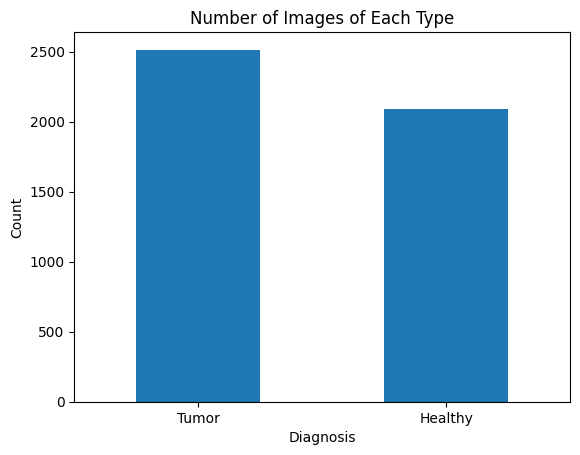

In [644]:
diagnosis2 = df['Diagnosis'].value_counts()
diagnosis2.plot(kind='bar')
plt.title('Number of Images of Each Type')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

There are slightly more images of tumors than there are images of healthy brains.

Split the images file paths into a test set and a training set.

In [645]:
train_images, test_images = train_test_split(df, test_size=0.25, random_state=47)

Perform data augmentation of the images and create two sets the training images and the test images

In [646]:
image_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [647]:
train_data = image_gen.flow_from_dataframe(train_images, x_col='File_Path', y_col='Diagnosis', shuffle=False)
test_data = image_gen.flow_from_dataframe(test_images, x_col='File_Path', y_col='Diagnosis', shuffle=False)

Found 3450 validated image filenames belonging to 2 classes.
Found 1150 validated image filenames belonging to 2 classes.


Lets take a look at some of our images.

In [648]:
def show_generated_images(image_gen):
    classes = list(train_data.class_indices.keys())
    images, labels = next(image_gen)
    plt.figure(figsize=(20, 10))

    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.axis('off')
        plt.imshow((images[i]+1)/2)
        index = np.argmax(labels[i])
        
        if classes[index] == 'Tumor':
            plt.title(classes[index], color='red')
        else:
            plt.title(classes[index], color='green')

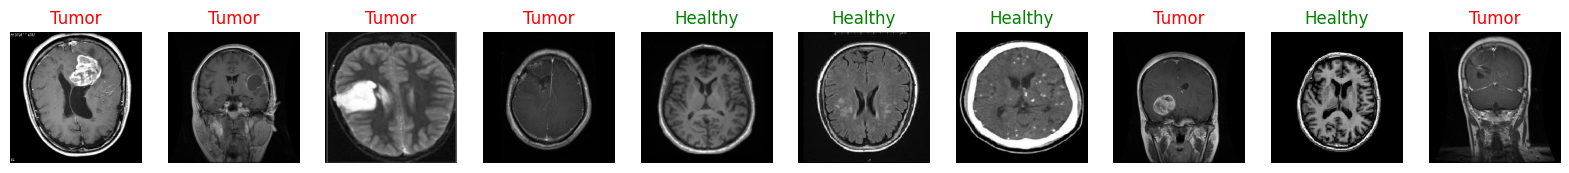

In [649]:
show_generated_images(train_data)